NAMA: MUHAMMAD IQBAL YOSHANDA

NIM: 4611420056

JUDUL SKRIPSI: PENINGKATAN AKURASI DETEKSI SERANGAN JARINGAN PADA INTRUSION DETECTION SYSTEM MENGGUNAKAN MODEL HIBRIDA CNN-BILSTM-GRU-PCA

#**IMPORT LIBRARY**

In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer


# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import Dense, Conv1D, Bidirectional, GRU, LSTM, MaxPool1D, Flatten, Dropout, BatchNormalization, Reshape, Activation # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model

# representation of model layers
from tensorflow.keras.utils import plot_model

#**LOAD DATA NSL-KDD**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#fungsi untuk memberikan feature pada dataset
def column_name(data):
  data.columns = [
      'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
      'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
      'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
      'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
      'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
      'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
      'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
  ]
  return data

In [ ]:
#fungsi untuk load dataset dari drive berformat csv
def load_data(url):
  return pd.read_csv(url, header=None)

##Load Data Train (KDDTrain+)

In [ ]:
#load data train
df_train = load_data('/content/drive/MyDrive/Persiapan Skripsi/Bismillah/IDS/dataset/NSL-KDD/KDDTrain+ (1).csv')
df_train = column_name(df_train)
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [ ]:
print(f'Jumlah baris: {df_train.shape[0]}, dan kolom: {df_train.shape[1]} - data train')

Jumlah baris: 125973, dan kolom: 43 - data train


##Load Data Test (KDDTest+)

In [ ]:
#load data test
df_test = load_data('/content/drive/MyDrive/Persiapan Skripsi/Bismillah/IDS/dataset/NSL-KDD/KDDTest+ (1).csv')
df_test = column_name(df_test)
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [ ]:
print(f'Jumlah baris: {df_test.shape[0]}, dan kolom: {df_test.shape[1]} - data test')

Jumlah baris: 22544, dan kolom: 43 - data test


#**PRAPEMROSESAN DATA**

1. Data Cleaning
2. Normalisasi Data & Reduksi Dimensi Data (PCA)
3. Transformasi Data (labeling encode & one-hot encoding)

##Data Cleaning

###Hapus kolom yang tidak digunakan

In [ ]:
#fungsi untuk menghapus kolom yang tidak terpakai
def column_drop(data, kolom):
  return data.drop(kolom, axis='columns', inplace=True)

In [ ]:
#menghapus kolom difficulty level pada data train dan test
column_drop(df_train, 'difficulty_level')
column_drop(df_test, 'difficulty_level')

In [ ]:
print(f'kolom data train: {df_train.columns}')
print(f'kolom data test: {df_test.columns}')

kolom data train: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')
kolom data test: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 

###Cek Missing Value

In [ ]:
#fungsi cek missing value
def missing_value_check(data):
  return data.isnull().sum()

In [ ]:
#cek missing value data train
missing_value_check(df_train)

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [ ]:
#cek missing value data test
missing_value_check(df_test)

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

##Normalisasi Data & Reduksi Dimensi Data (PCA)

###Normalisasi Data

In [ ]:
#sebelum data direduksi, data train dan test digabungkan menjadi satu data
df = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_columns = ["duration","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
x = df.loc[:, numeric_columns].values
y = df.loc[:, ['label']].values
data_normalisasi=StandardScaler().fit_transform(x)
print(data_normalisasi)

[[-1.12481056e-01 -7.34564438e-03 -4.61422891e-03 ... -5.84812691e-01
  -2.67150972e-01 -4.06814676e-01]
 [-1.12481056e-01 -7.40941997e-03 -4.61422891e-03 ... -5.84812691e-01
  -4.22074453e-01 -4.06814676e-01]
 [-1.12481056e-01 -7.43640906e-03 -4.61422891e-03 ...  1.74229525e+00
  -4.22074453e-01 -4.06814676e-01]
 ...
 [-1.12481056e-01  2.64567957e-03 -2.36933291e-03 ... -5.84812691e-01
  -2.05181580e-01 -1.98034706e-01]
 [-1.12481056e-01 -7.42864507e-03 -4.60288833e-03 ... -5.84812691e-01
  -4.22074453e-01 -4.06814676e-01]
 [-1.12481056e-01 -7.43640906e-03 -4.61422891e-03 ... -5.84812691e-01
   9.41252172e-01  2.57575633e+00]]


###Reduksi Dimensi Data (PCA)

In [ ]:
from sklearn.decomposition import PCA

#Inisialisasi objek PCA dengan jumlah komponen yang diinginkan
pca = PCA(n_components=7)

#Fit dan transformasi data yang telah dinormalisasi ke dalam komponen utama
principal_components = pca.fit_transform(data_normalisasi)

#hasil data yg telah direduksi dibuat dataframe kembali
principal_df = pd.DataFrame(data=principal_components, columns=['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7'])

In [ ]:
#menggabungkan kembali data dengan kolom categorical
df_final = pd.concat([principal_df, df[['protocol_type', 'service', 'flag','label']]], axis=1)
df_final

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,protocol_type,service,flag,label
0,-0.625567,-0.073870,-0.013914,-0.178437,-0.324832,0.203772,-0.136712,tcp,ftp_data,SF,normal
1,0.759516,0.940534,0.035050,-1.272308,-0.774773,1.760065,-0.534240,udp,other,SF,normal
2,3.736309,-1.948467,0.018748,-0.131396,-0.235247,-0.435258,0.043089,tcp,private,S0,neptune
3,-2.363436,-0.946042,-0.083091,0.243288,-0.088843,-0.979926,0.109364,tcp,http,SF,normal
4,-2.152525,-0.733130,-0.127414,1.063417,0.770453,-0.421654,-0.101344,tcp,http,SF,normal
...,...,...,...,...,...,...,...,...,...,...,...
148512,-1.953260,-0.533973,-0.033848,0.478489,-0.214547,-0.686800,-0.072720,tcp,smtp,SF,normal
148513,-2.377054,-0.742629,-0.111635,0.718071,0.350646,-0.730649,-0.035599,tcp,http,SF,normal
148514,-2.236359,-0.567155,-0.078114,1.285549,0.066730,-0.396521,0.054383,tcp,http,SF,back
148515,-1.745883,-0.532736,-0.159302,0.268957,0.573631,-0.240507,-0.015060,udp,domain_u,SF,normal


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Component 1    148517 non-null  float64
 1   Component 2    148517 non-null  float64
 2   Component 3    148517 non-null  float64
 3   Component 4    148517 non-null  float64
 4   Component 5    148517 non-null  float64
 5   Component 6    148517 non-null  float64
 6   Component 7    148517 non-null  float64
 7   protocol_type  148517 non-null  object 
 8   service        148517 non-null  object 
 9   flag           148517 non-null  object 
 10  label          148517 non-null  object 
dtypes: float64(7), object(4)
memory usage: 12.5+ MB


##Tranformasi Data (labeling encode & one-hot encoding)

###Labeling (Dos, Probe, R2L, U2R, normal)

In [ ]:
df_final['label'].value_counts()

normal             77054
neptune            45871
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
loadmodule            11
ftp_write             11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm               2


In [ ]:
#Fungsi mengubah jenis serangan pada label kedalam kategori serangan Dos, R2L, Probe, dan U2R
def change_label(data):
  data.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  data.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  data.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  data.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [ ]:
change_label(df_final)

In [ ]:
df_final['label'].value_counts()

normal    77054
Dos       53387
Probe     14077
R2L        3880
U2R         119
Name: label, dtype: int64

###Labeling Encode

In [ ]:
#Membuat sebuah dataframe dengan berisi label (Dos, Probe, R2L, U2R, normal) untuk nantinya di encode
multi_label = pd.DataFrame(df_final.label)

In [ ]:
# label di encode menjadi 0 = Dos , 1 = Probe, 2 = R2L, 3 = U2R, 4 = normal
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
df_final['intrusion'] = enc_label

In [ ]:
df_final.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,protocol_type,service,flag,label,intrusion
0,-0.625567,-0.073870,-0.013914,-0.178437,-0.324832,0.203772,-0.136712,tcp,ftp_data,SF,normal,4
1,0.759516,0.940534,0.035050,-1.272308,-0.774773,1.760065,-0.534240,udp,other,SF,normal,4
2,3.736309,-1.948467,0.018748,-0.131396,-0.235247,-0.435258,0.043089,tcp,private,S0,Dos,0
3,-2.363436,-0.946042,-0.083091,0.243288,-0.088843,-0.979926,0.109364,tcp,http,SF,normal,4
4,-2.152525,-0.733130,-0.127414,1.063417,0.770453,-0.421654,-0.101344,tcp,http,SF,normal,4


###One-Hot Encoding

In [ ]:
#menghapus kolom label karena sudah di encode pada kolom intrusion
column_drop(df_final, 'label')

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Component 1    148517 non-null  float64
 1   Component 2    148517 non-null  float64
 2   Component 3    148517 non-null  float64
 3   Component 4    148517 non-null  float64
 4   Component 5    148517 non-null  float64
 5   Component 6    148517 non-null  float64
 6   Component 7    148517 non-null  float64
 7   protocol_type  148517 non-null  object 
 8   service        148517 non-null  object 
 9   flag           148517 non-null  object 
 10  intrusion      148517 non-null  int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 12.5+ MB


In [ ]:
#one-hot encoding
df_final = pd.get_dummies(df_final, columns=['protocol_type', 'service', 'flag'], prefix="", prefix_sep="")

In [ ]:
df_final

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,intrusion,icmp,tcp,...,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,-0.625567,-0.073870,-0.013914,-0.178437,-0.324832,0.203772,-0.136712,4,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.759516,0.940534,0.035050,-1.272308,-0.774773,1.760065,-0.534240,4,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3.736309,-1.948467,0.018748,-0.131396,-0.235247,-0.435258,0.043089,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,-2.363436,-0.946042,-0.083091,0.243288,-0.088843,-0.979926,0.109364,4,0,1,...,0,0,0,0,0,0,0,0,1,0
4,-2.152525,-0.733130,-0.127414,1.063417,0.770453,-0.421654,-0.101344,4,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-1.953260,-0.533973,-0.033848,0.478489,-0.214547,-0.686800,-0.072720,4,0,1,...,0,0,0,0,0,0,0,0,1,0
148513,-2.377054,-0.742629,-0.111635,0.718071,0.350646,-0.730649,-0.035599,4,0,1,...,0,0,0,0,0,0,0,0,1,0
148514,-2.236359,-0.567155,-0.078114,1.285549,0.066730,-0.396521,0.054383,0,0,1,...,0,0,0,0,0,0,0,0,1,0
148515,-1.745883,-0.532736,-0.159302,0.268957,0.573631,-0.240507,-0.015060,4,0,0,...,0,0,0,0,0,0,0,0,1,0


##Train & Test Set

In [ ]:
#menginisiasi x_train (keseluruhan fitur/kolom kecuali kolom intrusion) dan y_train (hanya kolom intrusion)
y_train_multi= df_final[['intrusion']]
x_train_multi= df_final.drop(labels=['intrusion'], axis=1)

print(f'bentuk x_train: {x_train_multi.shape} - 86 kolom \n bentuk y_train: {y_train_multi.shape} - 1 kolom (intrusion)')

bentuk x_train: (148517, 91) - 86 kolom 
 bentuk y_train: (148517, 1) - 1 kolom (intrusion)


In [ ]:
#y_train yang terdiri dari kolom intrusion (0, 1, 2, 3, 4) diubah dalam bentuk biner
from sklearn.preprocessing import LabelBinarizer

y_train_multi = LabelBinarizer().fit_transform(y_train_multi)
y_train_multi

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

###Mengubah bentuk data menjadi array

In [ ]:
#sebelum diubah
x_train_multi.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,icmp,tcp,udp,...,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,-0.625485,-0.073629,-0.016600,-0.170794,-0.324501,0.192938,0.028035,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0.759764,0.941010,0.032965,-1.266440,-0.774659,1.742514,-0.288705,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,3.736300,-1.948489,0.018585,-0.129364,-0.235693,-0.435318,0.037721,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,-2.363555,-0.946207,-0.077360,0.243349,-0.081351,-0.962852,0.016112,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,-2.152489,-0.733108,-0.128742,1.060885,0.770989,-0.427492,-0.077143,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
x_train_multi=np.array(x_train_multi) #digunakan untuk training (data source)
y_train_multi=np.array(y_train_multi) #digunakan untuk testing (data source)

In [ ]:
#sesudah diubah
x_train_multi

array([[-0.62548464, -0.07362944, -0.01660039, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.75976406,  0.94100992,  0.03296519, ...,  0.        ,
         1.        ,  0.        ],
       [ 3.73630001, -1.94848865,  0.01858544, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.23628484, -0.56710144, -0.08070786, ...,  0.        ,
         1.        ,  0.        ],
       [-1.74577803, -0.53264913, -0.16575478, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.27327653,  5.05370824, -0.12626   , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
y_train_multi

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

###Split Train & Test Set (80:20)

In [ ]:
#membagi dataset menjadi 80% untuk training dan 20% untuk testing
x_train, x_test, y_train, y_test = train_test_split(x_train_multi, y_train_multi, test_size=0.20, random_state=42)

###Reshape data agar cocok dan bisa digunakan untuk model CNN

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(118813, 91, 1)

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(29704, 91, 1)

##Modeling CNN-BILSTM-GRU

In [ ]:
model = Sequential() # inisialisasi model
# input layer dan first layer dengan 50 neurons
model.add(Conv1D(filters = 64, kernel_size = 91, padding="same", input_shape = (91, 1), activation='relu')) #convolution
model.add(MaxPool1D(pool_size=(4))) #pooling

model.add(Bidirectional(LSTM(64, return_sequences=True))) #menambahkan BiLSTM model
model.add(Dropout(0.5))

model.add(GRU(128,return_sequences=True)) #menambahkan GRU model
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=50)) #full connection
model.add(Dropout(0.5))
# output layer dengan softmax activation
model.add(Dense(units=5,activation='softmax'))

optimizer = Adam()

In [ ]:
#compiling model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# summary dari model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 91, 64)            5888      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 22, 64)            0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 22, 128)           66048     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 22, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 22, 128)           99072     
                                                                 
 dropout_3 (Dropout)         (None, 22, 128)          

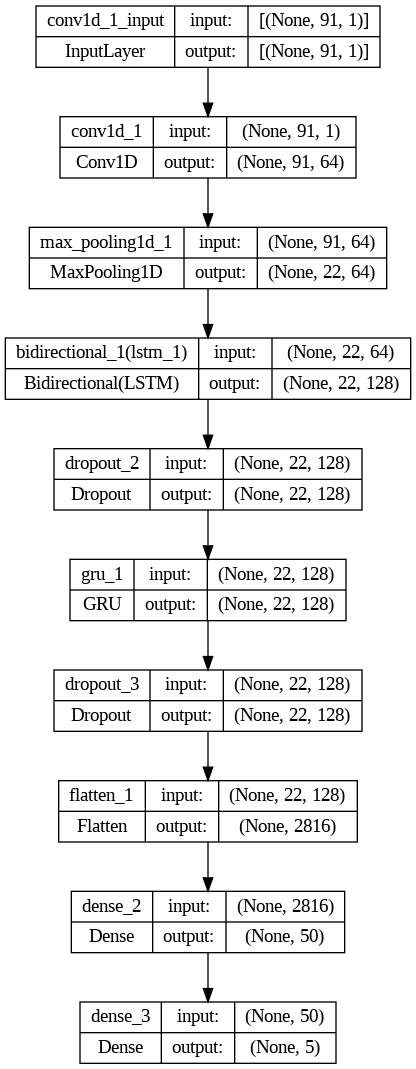

In [ ]:
plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)

###Early Stopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

###Training Model

In [ ]:
# training model pada training dataset
history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1486/1486 [==============================] - 203s 132ms/step - loss: 0.1307 - accuracy: 0.9565 - val_loss: 0.0701 - val_accuracy: 0.9747
Epoch 2/100
1486/1486 [==============================] - 194s 131ms/step - loss: 0.0749 - accuracy: 0.9741 - val_loss: 0.0681 - val_accuracy: 0.9761
Epoch 3/100
1486/1486 [==============================] - 196s 132ms/step - loss: 0.0679 - accuracy: 0.9763 - val_loss: 0.0658 - val_accuracy: 0.9785
Epoch 4/100
1486/1486 [==============================] - 190s 128ms/step - loss: 0.0643 - accuracy: 0.9773 - val_loss: 0.0634 - val_accuracy: 0.9775
Epoch 5/100
1486/1486 [==============================] - 196s 132ms/step - loss: 0.0608 - accuracy: 0.9784 - val_loss: 0.0591 - val_accuracy: 0.9810
Epoch 6/100
1486/1486 [==============================] - 195s 132ms/step - loss: 0.0584 - accuracy: 0.9793 - val_loss: 0.0661 - val_accuracy: 0.9766
Epoch 7/100
1486/1486 [==============================] - 194s 131ms/step - loss: 0.0554 - accuracy: 0.9803

###Accuracy Model

In [ ]:
# Memprediksi target attribute pada testing dataset
test_results = model.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 [==============================] - 22s 24ms/step - loss: 0.0377 - accuracy: 0.9881
Test results - Loss: 0.03774483501911163 - Accuracy: 98.81497621536255%


###Accuracy & Loss Graph

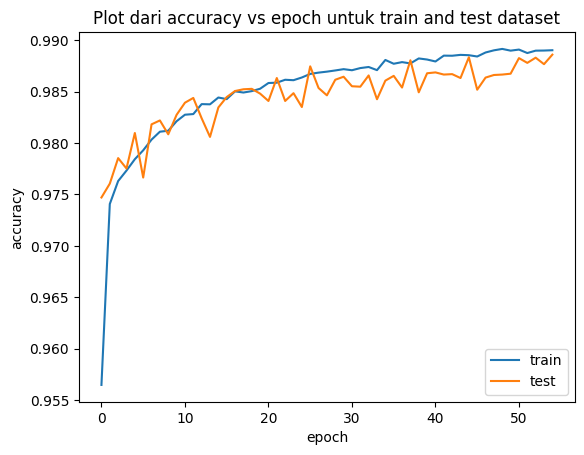

In [ ]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot dari accuracy vs epoch untuk train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

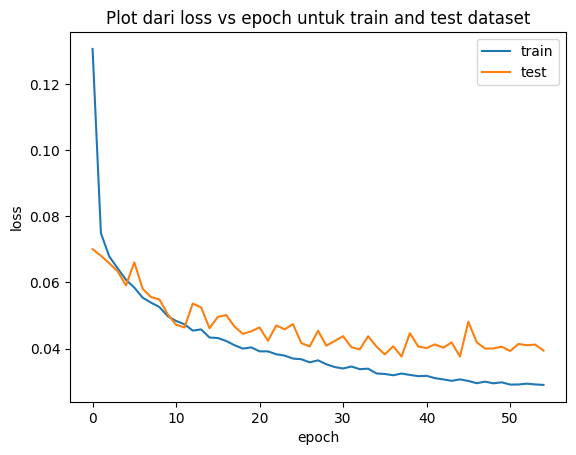

In [ ]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot dari loss vs epoch untuk train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

###Confusion Matrix

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

929/929 [==============================] - 23s 23ms/step


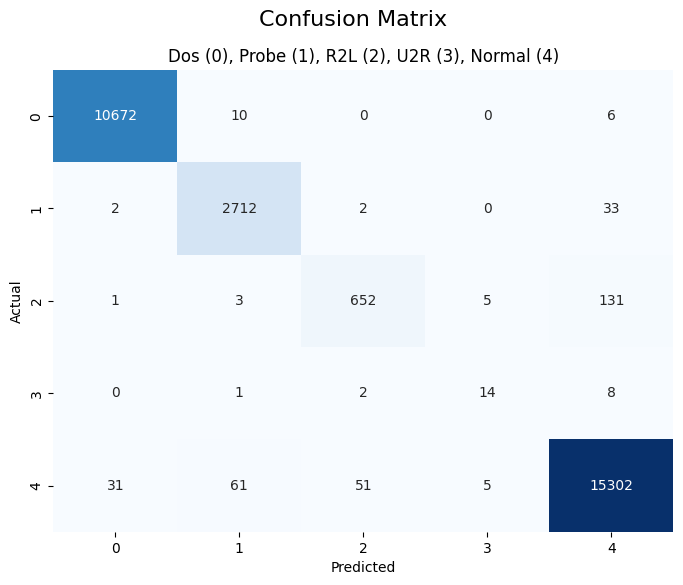

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.suptitle('Confusion Matrix', fontsize=16)
plt.title('Dos (0), Probe (1), R2L (2), U2R (3), Normal (4)')
plt.show()

###True Positive

In [ ]:
#mendapatkan true positive untuk masing-masing kelas

TP_class_0 = cm[0, 0]
# TP untuk kelas ke-1
TP_class_1 = cm[1, 1]
# TP untuk kelas ke-2
TP_class_2 = cm[2, 2]
# TP untuk kelas ke-3
TP_class_3 = cm[3, 3]
# TP untuk kelas ke-4
TP_class_4 = cm[4, 4]

print(f"True Positive (TP) untuk kelas Dos    : {TP_class_0}")
print(f"True Positive (TP) untuk kelas Probe  : {TP_class_1}")
print(f"True Positive (TP) untuk kelas R2L    : {TP_class_2}")
print(f"True Positive (TP) untuk kelas U2R    : {TP_class_3}")
print(f"True Positive (TP) untuk kelas Normal : {TP_class_4}")

True Positive (TP) untuk kelas Dos    : 10672
True Positive (TP) untuk kelas Probe  : 2712
True Positive (TP) untuk kelas R2L    : 652
True Positive (TP) untuk kelas U2R    : 14
True Positive (TP) untuk kelas Normal : 15302


###False Negative

In [ ]:
# Mendapatkan nilai False Negative (FN) untuk masing-masing kelas
# FN untuk kelas ke-0
FN_class_0 = sum(cm[0, :]) - cm[0, 0]
# FN untuk kelas ke-1
FN_class_1 = sum(cm[1, :]) - cm[1, 1]
# FN untuk kelas ke-2
FN_class_2 = sum(cm[2, :]) - cm[2, 2]
# FN untuk kelas ke-3
FN_class_3 = sum(cm[3, :]) - cm[3, 3]
# FN untuk kelas ke-4
FN_class_4 = sum(cm[4, :]) - cm[4, 4]

print(f"False Negative (FN) untuk Dos   : {FN_class_0}")
print(f"False Negative (FN) untuk Probe : {FN_class_1}")
print(f"False Negative (FN) untuk R2L   : {FN_class_2}")
print(f"False Negative (FN) untuk U2R   : {FN_class_3}")
print(f"False Negative (FN) untuk Normal: {FN_class_4}")

False Negative (FN) untuk Dos   : 16
False Negative (FN) untuk Probe : 37
False Negative (FN) untuk R2L   : 140
False Negative (FN) untuk U2R   : 11
False Negative (FN) untuk Normal: 148


###True Negative

In [ ]:
TN_class_0 = sum(sum(cm)) - sum(cm[0, :]) - sum(cm[:, 0]) + cm[0, 0]
# TN untuk kelas ke-1
TN_class_1 = sum(sum(cm)) - sum(cm[1, :]) - sum(cm[:, 1]) + cm[1, 1]
# TN untuk kelas ke-2
TN_class_2 = sum(sum(cm)) - sum(cm[2, :]) - sum(cm[:, 2]) + cm[2, 2]
# TN untuk kelas ke-3
TN_class_3 = sum(sum(cm)) - sum(cm[3, :]) - sum(cm[:, 3]) + cm[3, 3]
# TN untuk kelas ke-4
TN_class_4 = sum(sum(cm)) - sum(cm[4, :]) - sum(cm[:, 4]) + cm[4, 4]

print(f"True Negative (TN) untuk Dos    : {TN_class_0}")
print(f"True Negative (TN) untuk Probe  : {TN_class_1}")
print(f"True Negative (TN) untuk R2L    : {TN_class_2}")
print(f"True Negative (TN) untuk U2R    : {TN_class_3}")
print(f"True Negative (TN) untuk Normal : {TN_class_4}")

True Negative (TN) untuk Dos    : 18982
True Negative (TN) untuk Probe  : 26880
True Negative (TN) untuk R2L    : 28857
True Negative (TN) untuk U2R    : 29669
True Negative (TN) untuk Normal : 14076


##False positive

In [ ]:
# Mendapatkan nilai False Positive (FP) untuk masing-masing kelas
# FP untuk kelas ke-0
FP_class_0 = sum(cm[:, 0]) - cm[0, 0]
# FP untuk kelas ke-1
FP_class_1 = sum(cm[:, 1]) - cm[1, 1]
# FP untuk kelas ke-2
FP_class_2 = sum(cm[:, 2]) - cm[2, 2]
# FP untuk kelas ke-3
FP_class_3 = sum(cm[:, 3]) - cm[3, 3]
# FP untuk kelas ke-4
FP_class_4 = sum(cm[:, 4]) - cm[4, 4]

print(f"False Positive (FP) untuk Dos   : {FP_class_0}")
print(f"False Positive (FP) untuk Probe : {FP_class_1}")
print(f"False Positive (FP) untuk R2L   : {FP_class_2}")
print(f"False Positive (FP) untuk U2R   : {FP_class_3}")
print(f"False Positive (FP) untuk Normal: {FP_class_4}")

False Positive (FP) untuk Dos   : 34
False Positive (FP) untuk Probe : 75
False Positive (FP) untuk R2L   : 55
False Positive (FP) untuk U2R   : 10
False Positive (FP) untuk Normal: 178


###False Negative Rate & True Positive Rate

In [ ]:
FNR_0 = FN_class_0 / (FN_class_0 + TP_class_0)
TPR_0 = TP_class_0 / (TP_class_0 + FN_class_0)

FNR_1 = FN_class_1 / (FN_class_1 + TP_class_1)
TPR_1 = TP_class_1 / (TP_class_1 + FN_class_1)

FNR_2 = FN_class_2 / (FN_class_2 + TP_class_2)
TPR_2 = TP_class_2 / (TP_class_2 + FN_class_2)

FNR_3 = FN_class_3 / (FN_class_3 + TP_class_3)
TPR_3 = TP_class_3 / (TP_class_3 + FN_class_3)

FNR_4 = FN_class_4 / (FN_class_4 + TP_class_4)
TPR_4 = TP_class_4 / (TP_class_4 + FN_class_4)


print(f"  False Negative Rate (FNR) Dos     : {FNR_0*100:.2f}%,   True Positive Rate (TPR) Dos    : {TPR_0*100:.2f}%")
print(f"  False Negative Rate (FNR) Probe   : {FNR_1*100:.2f}%,   True Positive Rate (TPR) Probe  : {TPR_1*100:.2f}%")
print(f"  False Negative Rate (FNR) R2L     : {FNR_2*100:.2f}%,  True Positive Rate (TPR) R2L    : {TPR_2*100:.2f}%")
print(f"  False Negative Rate (FNR) U2R     : {FNR_3*100:.2f}%,  True Positive Rate (TPR) U2R    : {TPR_3*100:.2f}%")
print(f"  False Negative Rate (FNR) Normal  : {FNR_4*100:.2f}%,   True Positive Rate (TPR) Normal : {TPR_4*100:.2f}%")

  False Negative Rate (FNR) Dos     : 0.15%,   True Positive Rate (TPR) Dos    : 99.85%
  False Negative Rate (FNR) Probe   : 1.35%,   True Positive Rate (TPR) Probe  : 98.65%
  False Negative Rate (FNR) R2L     : 17.68%,  True Positive Rate (TPR) R2L    : 82.32%
  False Negative Rate (FNR) U2R     : 44.00%,  True Positive Rate (TPR) U2R    : 56.00%
  False Negative Rate (FNR) Normal  : 0.96%,   True Positive Rate (TPR) Normal : 99.04%


###False Alarm Rate

In [ ]:
FAR_class_0 = FP_class_0 / (TN_class_0 + FP_class_0)
FAR_class_1 = FP_class_1 / (TN_class_1 + FP_class_1)
FAR_class_2 = FP_class_2 / (TN_class_2 + FP_class_2)
FAR_class_3 = FP_class_3 / (TN_class_3 + FP_class_3)
FAR_class_4 = FP_class_4 / (TN_class_4 + FP_class_4)

print(f"False Alarm Rate (FAR) untuk Dos    : {round(FAR_class_0*100, 2):.2f}%")
print(f"False Alarm Rate (FAR) untuk Probe  : {round(FAR_class_1*100, 2):.2f}%")
print(f"False Alarm Rate (FAR) untuk R2L    : {round(FAR_class_2*100, 2):.2f}%")
print(f"False Alarm Rate (FAR) untuk U2R    : {round(FAR_class_3*100, 2):.2f}%")
print(f"False Alarm Rate (FAR) untuk Normal : {round(FAR_class_4*100, 2):.2f}%")

False Alarm Rate (FAR) untuk Dos    : 0.18%
False Alarm Rate (FAR) untuk Probe  : 0.28%
False Alarm Rate (FAR) untuk R2L    : 0.19%
False Alarm Rate (FAR) untuk U2R    : 0.03%
False Alarm Rate (FAR) untuk Normal : 1.25%


###Precision, Recall, F1-Score

In [ ]:
#micro f1
print('Micro Precision: {:.2f}'.format(precision_score(y_true_classes, y_pred_classes, average='micro')))
print('Micro Recall   : {:.2f}'.format(recall_score(y_true_classes, y_pred_classes, average='micro')))
print('Micro F1-score : {:.2f}\n'.format(f1_score(y_true_classes, y_pred_classes, average='micro')))

Micro Precision: 0.99
Micro Recall   : 0.99
Micro F1-score : 0.99



In [ ]:
#macro f1
print('\nClassification Report\n')
print(classification_report(y_true_classes, y_pred_classes))


Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10688
           1       0.97      0.99      0.98      2749
           2       0.92      0.82      0.87       792
           3       0.58      0.56      0.57        25
           4       0.99      0.99      0.99     15450

    accuracy                           0.99     29704
   macro avg       0.89      0.87      0.88     29704
weighted avg       0.99      0.99      0.99     29704

